In [6]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
from os import walk

%matplotlib inline
import matplotlib
import datetime as dt

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
tf.test.is_gpu_available()

True

In [8]:
tf.version.VERSION
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# The Power Consumption Dataset
The dataset contains 7 different features such as Global_active_power, Global_reactive_power, and Voltage. These were collected every minute beginning in 2006. This dataset was found on Kaggle.

In [9]:
cwd = os.getcwd()
pardir = os.path.dirname(cwd)
_, _, filenames = next(walk(pardir))
filenames

['household_power_consumption.txt']

In [10]:
df = pd.read_csv(os.path.join(pardir, filenames[0]), sep=';', parse_dates={'dt':['Date','Time']}, 
                 low_memory=False, na_values=['nan','?'])

## Checking for Null Values
It looks like there are about 25,979 null values out of 2,075,259. That's approximately 1% of the data. Also, from below I can see that the null data values are all in the same row.

In [11]:
df.isnull().sum()

dt                           0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [12]:
df[df['Global_active_power'].isnull()].head(20)

,dt,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
6839,2006-12-21 11:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6840,2006-12-21 11:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19724,2006-12-30 10:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19725,2006-12-30 10:09:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41832,2007-01-14 18:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61909,2007-01-28 17:13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98254,2007-02-22 22:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98255,2007-02-22 22:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142588,2007-03-25 17:52:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190497,2007-04-28 00:21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, I'll need to decide what to do with the null data. One possibility is to drop the data, but then I would have gaps in the timeseries. Another possibility is to fill in the data with the average. But I don't think that's the best option since maybe the data just before the null values were at a low or at a high. Then filling it with the average would cause an upward/downward spike. I think the best option would be to backfill or forward fill the data. I think this makes the most sense since the data is in chronological order. I am going to choose ffill, which will propogate the last valid observation forward.

In [13]:
df = df.fillna(method='ffill', axis=0)
df.isnull().sum()

dt                       0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [14]:
df_backup = df

This project will just deal with hourly predictions, so I'll start by sub-sampling the data from 1 minute intervals to 1h

In [15]:
# slice [start:stop:step], starting from index 36 take every 60th record
df = df[36::60]
date_time = df.pop('dt')

In [16]:
date_time

36        2006-12-16 18:00:00
96        2006-12-16 19:00:00
156       2006-12-16 20:00:00
216       2006-12-16 21:00:00
276       2006-12-16 22:00:00
                  ...        
2075016   2010-11-26 17:00:00
2075076   2010-11-26 18:00:00
2075136   2010-11-26 19:00:00
2075196   2010-11-26 20:00:00
2075256   2010-11-26 21:00:00
Name: dt, Length: 34588, dtype: datetime64[ns]

Here are the first few rows of data:

In [17]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
36,2.790,0.180,237.52,11.8,0.0,0.0,18.0
96,4.070,0.088,231.99,17.4,0.0,1.0,17.0
156,3.206,0.078,232.43,13.8,0.0,0.0,16.0
216,3.314,0.072,236.76,14.0,0.0,0.0,17.0
276,3.464,0.170,236.03,14.6,0.0,1.0,17.0


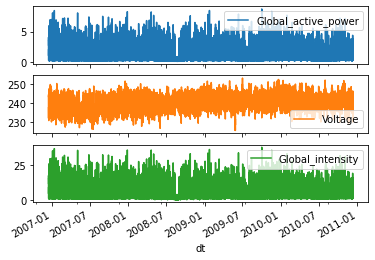

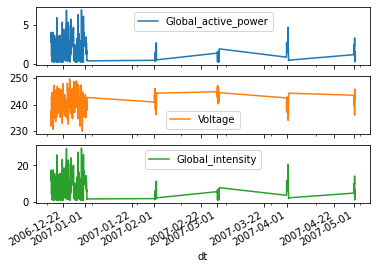

In [18]:
plot_cols = ['Global_active_power','Voltage','Global_intensity']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

## Inspect data

In [19]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34588.0,1.092031,1.058231,0.078,0.308,0.602,1.532,8.758
Global_reactive_power,34588.0,0.123175,0.113308,0.000,0.048,0.100,0.194,1.218
Voltage,34588.0,240.720039,3.233447,225.540,238.870,240.890,242.790,253.170
Global_intensity,34588.0,4.631178,4.451695,0.200,1.400,2.600,6.400,37.600
Sub_metering_1,34588.0,1.096999,6.078537,0.000,0.000,0.000,0.000,80.000
Sub_metering_2,34588.0,1.314155,5.883268,0.000,0.000,0.000,1.000,79.000
Sub_metering_3,34588.0,6.463687,8.444149,0.000,0.000,1.000,17.000,31.000


By inspecting the data, I can see that Sub_metering_1 and Sub_metering_2 are primarily full of 0's, although when approaching the max, they increase up to 79 and 80 respectively.

Also, I can see that the Global_active_power, Global_reactive_power, Voltage, and Global_intensity all have a relatively small standard deviation with 4.45 being the maximum standard deviation.

After inspecting the data, nothing stands out as needing to be cleaned up aside from filling the null values which was done previously. I was also checking to see if any of the columns had negative values, since that would have stood out as being out of the ordinary.

# Feature Engineering
The Date Time column is very useful, but not in this string form. I'll start by converting it to seconds

In [21]:
timestamp_s = date_time.map(dt.datetime.timestamp)

Since this is power consumption data, it may have some type of periodicity. I'm unsure of which frequencies are important. But I can figure this out by using an fft.

In [ ]:
fft = tf.signal.rfft(df['Global_active_power'])
f_per_dataset = np.arange(0, len(fft))


In [ ]:
n_samples_h = len(df['Global_active_power'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

In [ ]:
f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year','1/day'])
_ = plt.xlabel('Frequency (log scale)')